# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
def l2_norm(x):
    return np.sqrt(np.sum(x**2))

In [5]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss_history = []
        self.iter_count = 0
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        return 1 / (1 + np.exp(-X.dot(weights)))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        loss = np.sum(np.log(1 + np.exp(-x.dot(weights) * y)))/len(x)
        reg_loss = l2_norm(weights)**2 / (2 * self.C)
        return loss + reg_loss
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        self.loss_history = []
        for i in range(self.max_iter):
            self.loss_history.append(self.get_loss(X_ext, self.weights_, y))
            prev_weights = self.weights_.copy()
            delta = -np.sum(X_ext.T * y * (1 - (1 / (1 + np.exp(-X_ext.dot(self.weights_)*y)))), axis=1) / len(X)
            delta += self.weights_ / self.C
            self.weights_ -= self.eta * delta
            if l2_norm(prev_weights - self.weights_) < self.tol:
                break
        self.iter_count = i
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        probabilities = self.predict_proba(X)
        return (probabilities > 0.5) * 2 - 1 

In [6]:
from sklearn import datasets
from sklearn import metrics

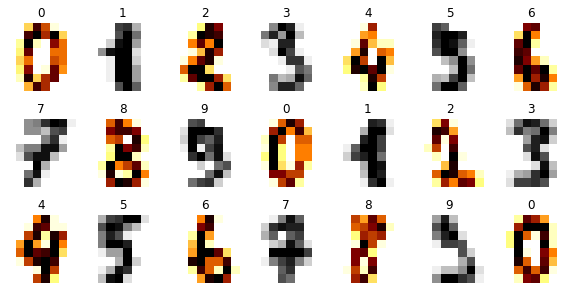

In [7]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [8]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [9]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [10]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [11]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [12]:
lr_clf.fit(X_train, y_train)

In [13]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [14]:
model = CustomLogisticRegression()

C:\Users\Kirill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


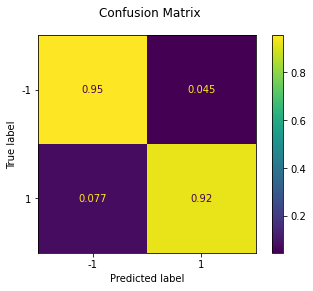

In [15]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [16]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [17]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

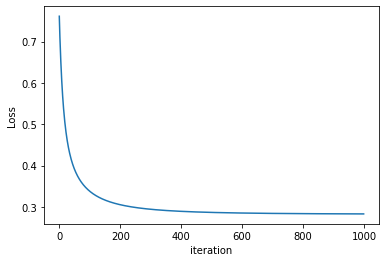

In [18]:
plt.plot(model.loss_history)
plt.xlabel('iteration');
plt.ylabel('Loss');

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

C:\Users\Kirill\AppData\Local\Temp\ipykernel_4932\2468867387.py:37: RuntimeWarning: overflow encountered in exp
  loss = np.sum(np.log(1 + np.exp(-x.dot(weights) * y)))/len(x)
C:\Users\Kirill\AppData\Local\Temp\ipykernel_4932\2468867387.py:62: RuntimeWarning: overflow encountered in exp
  delta = -np.sum(X_ext.T * y * (1 - (1 / (1 + np.exp(-X_ext.dot(self.weights_)*y)))), axis=1) / len(X)


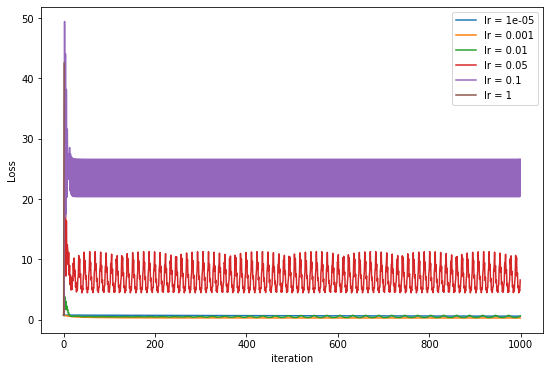

In [19]:
learning_rates = [0.00001, 0.001, 0.01, 0.05, 0.1, 1]

plt.figure(figsize=(9, 6))

for lr in learning_rates:
    clf = CustomLogisticRegression(eta = lr)
    clf.fit(X_train, y_train)
    plt.plot(clf.loss_history, label=f'lr = {lr}')
    
plt.xlabel('iteration');
plt.ylabel('Loss');
plt.legend(loc='best');

При больших значениях learning rate > 0.01 loss колеблется около большого значения. При learning rate = 1 обучение расходится

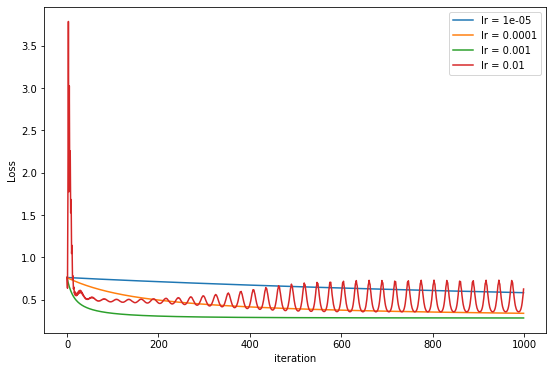

In [20]:
learning_rates = [0.00001, 0.0001, 0.001, 0.01]

plt.figure(figsize=(9, 6))

for lr in learning_rates:
    clf = CustomLogisticRegression(eta = lr)
    clf.fit(X_train, y_train)
    plt.plot(clf.loss_history, label=f'lr = {lr}')
    
plt.xlabel('iteration');
plt.ylabel('Loss');
plt.legend(loc='best');

lr = 0.01 тоже является слишком большим. lr = 0.00001 является слишком маленьким: процесс обучения сходится очень долго. Оптимальный learning rate находится между 0.0001 и 0.001

**(0.5 points)** Try different regularization parameter values and compare the model quality.

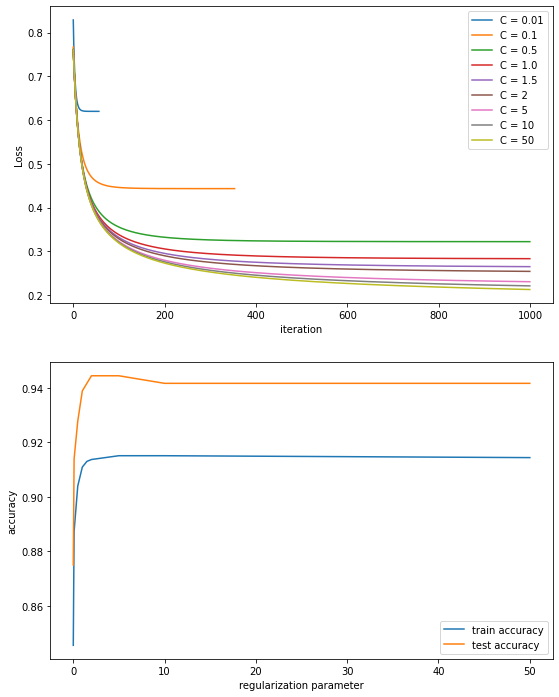

In [21]:
Cs = [0.01, 0.1, 0.5, 1., 1.5, 2, 5, 10, 50]

_, ax = plt.subplots(nrows=2, ncols=1, figsize=(9, 12))

train_acc, test_acc = [], []
for C in Cs:
    clf = CustomLogisticRegression(C = C)
    clf.fit(X_train, y_train)
    ax[0].plot(clf.loss_history, label=f'C = {C}')
    train_acc.append(accuracy_score(y_true=y_train, y_pred=clf.predict(X_train)))
    test_acc.append(accuracy_score(y_true=y_test, y_pred=clf.predict(X_test)))
    
ax[0].set_xlabel('iteration');
ax[0].set_ylabel('Loss');
ax[0].legend(loc='best');

ax[1].plot(Cs, train_acc, label='train accuracy');
ax[1].plot(Cs, test_acc, label='test accuracy');
ax[1].set_xlabel('regularization parameter');
ax[1].set_ylabel('accuracy')
ax[1].legend(loc='best')

In [22]:
best_C_idx = np.argmax(test_acc)
best_C = Cs[best_C_idx]
print(best_C)

2


При C < 1 регуляризация ограничивает веса слишком сильно, в результате получаем низкую точность. При C=2 достигается наибольшая точность на тестовом наборе данных

**(0.5 points)** Compare zero initialization and random initialization. 

True 1947
Acc:  0.9444444444444444
False 1999
Acc:  0.9444444444444444


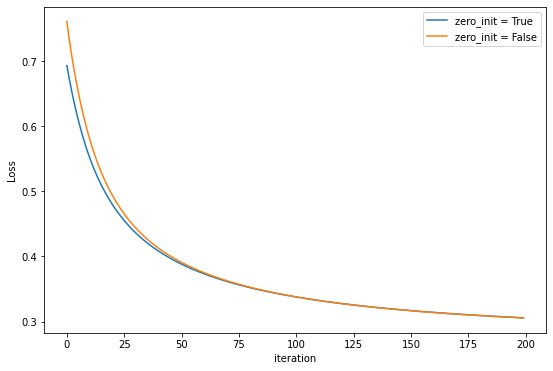

In [23]:
zero_init = [True, False]

plt.figure(figsize=(9, 6))

for zi in zero_init:
    clf = CustomLogisticRegression(zero_init=zi, max_iter=10000)
    clf.fit(X_train, y_train)
    plt.plot(clf.loss_history[:200], label=f'zero_init = {zi}')
    print(zi, clf.iter_count)
    print('Acc: ', accuracy_score(y_true=y_test, y_pred=clf.predict(X_test)))
    
plt.xlabel('iteration');
plt.ylabel('Loss');
plt.legend(loc='best');

Если инициализировать веса нулями, то обучение сошлось немного быстрее, однако различия не существенные

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [24]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        return np.sqrt(((X[..., np.newaxis] - Y.T[np.newaxis,...])**2).sum(axis=1))
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        return ((y[..., np.newaxis] == np.array(self.classes_)[np.newaxis, ...]) * weights.reshape(-1,1)).sum(axis=0)
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = np.ones(P.shape) / (P + self.eps)
                
            y = np.zeros((X.shape[0], len(self.classes_)))
            for i, sample in enumerate(P):
                neighbors = np.argsort(sample)[:self.n_neighbors]
                neighbor_classes = self.y[neighbors]
                y[i] = self.get_class_weights(neighbor_classes, weights_of_points[i][neighbors])
                y[i] /= np.sum(y[i])
                
            return y
            
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        predictions = self.predict_proba(X)
        return self.classes_[np.argmax(predictions, axis=1)]

In [25]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [26]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [27]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

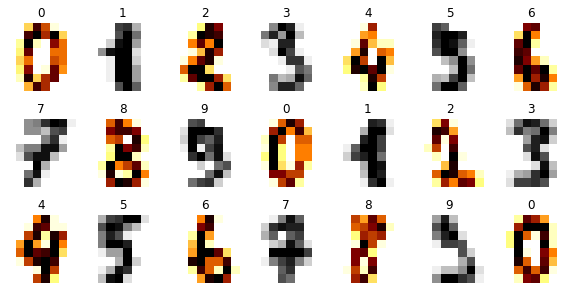

In [28]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [29]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [30]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

C:\Users\Kirill\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


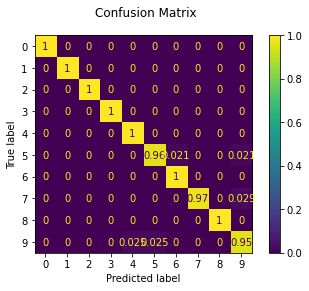

In [31]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [32]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

5 иногда распознаётся как 6 или 9 

7 иногда распознаётся как 9

9 иногра распознаётся как 4 или 5

Это происходит из-за похожего начертания этих цифр

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [33]:
clf = KNeighborsClassifier(n_neighbors=1, weights='distance')
clf.fit(X_train, y_train)
probas = clf.predict_proba(X_test)

print(np.sum((probas > 0.) & (probas < 1.)))

0


Если учитывать только одного ближайшего соседа, то каждый тестовый пример модель однозначно относит к некоторому классу

In [34]:
ks = np.arange(1,10)

for k in ks:
    clf = KNeighborsClassifier(n_neighbors=k, weights='distance')
    clf.fit(X_train, y_train)
    probas = clf.predict_proba(X_test)
    print(f'n_neighbors={k}:', np.sum((probas > 0.) & (probas < 1.)))

n_neighbors=1: 0
n_neighbors=2: 8
n_neighbors=3: 26
n_neighbors=4: 38
n_neighbors=5: 47
n_neighbors=6: 62
n_neighbors=7: 82
n_neighbors=8: 93
n_neighbors=9: 112


При увеличении количества соседей, которых нужно учитывать, количество примеров, на которых модель уверена на 100%, уменьшается

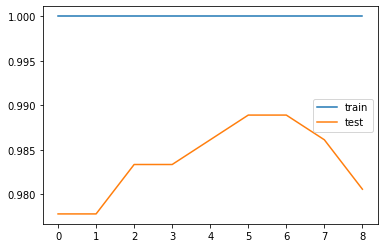

In [35]:
ks = np.arange(1,10)

train_acc, test_acc = [], []
for k in ks:
    clf = KNeighborsClassifier(n_neighbors=k, weights='distance')
    clf.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_true=y_train, y_pred=clf.predict(X_train)))
    test_acc.append(accuracy_score(y_true=y_test, y_pred=clf.predict(X_test)))
    
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.legend(loc='best')

Оптимальным количеством содей для данной задачи будет 5 или 6

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [36]:
knn_dist = KNeighborsClassifier(weights='distance')
knn_unif = KNeighborsClassifier(weights='uniform')

knn_dist.fit(X_train, y_train)
knn_unif.fit(X_train, y_train)

dist_acc = accuracy_score(y_true=y_test, y_pred=knn_dist.predict(X_test))
unif_acc = accuracy_score(y_true=y_test, y_pred=knn_unif.predict(X_test))

print('Accuracy:')
print('distance:', dist_acc)
print('uniform:', unif_acc)

Accuracy:
distance: 0.9861111111111112
uniform: 0.9861111111111112


В данном случае способ задачи весов не влияет на результат. Если объекты выборки находятся далеко друг от друга, то лучше использовать взвешивание по расстоянию, так как объекты в k ближайших соседей могут попасть объекты, которые находятся очень далеко от объекта, который нужно классифицировать.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [37]:
import seaborn as sns
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score

In [38]:
PATH = "./data/"

In [39]:
data = pd.read_csv(os.path.join(PATH, 'train.csv')).set_index('PassengerId')

In [40]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [41]:
data.Sex.value_counts()

male      56114
female    43886
Name: Sex, dtype: int64

<AxesSubplot:xlabel='Sex', ylabel='count'>

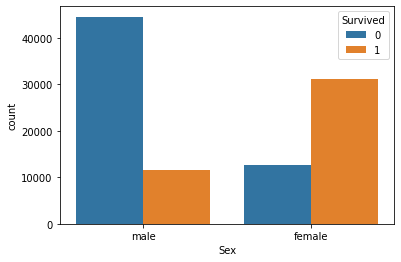

In [42]:
sns.countplot(x='Sex', hue='Survived', data=data)

Доля выживших женщин больше, чем доля выживших мужчин

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

<AxesSubplot:xlabel='Age', ylabel='Count'>

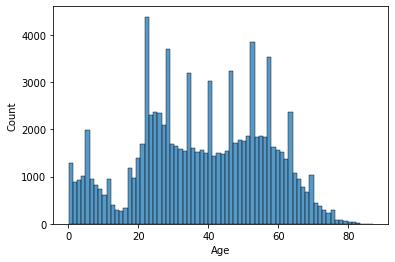

In [43]:
sns.histplot(x='Age', data=data)

In [44]:
data.Age.agg(['mean', 'median'])

mean      38.355472
median    39.000000
Name: Age, dtype: float64

<AxesSubplot:xlabel='Age', ylabel='Count'>

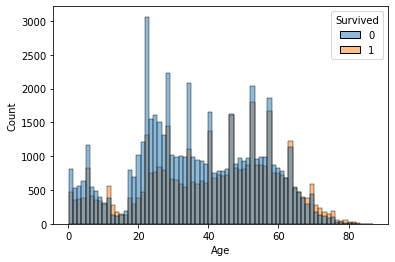

In [45]:
sns.histplot(x='Age', hue='Survived', data=data)

Распределения возраста для выживших и умерших различаются, так как спасали в первую очередь детей и стариков

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

<AxesSubplot:xlabel='Pclass', ylabel='count'>

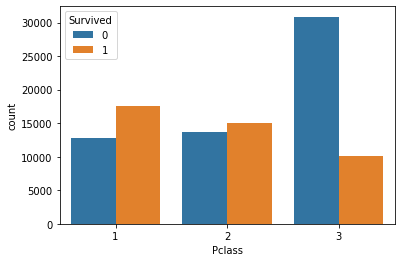

In [46]:
sns.countplot(x='Pclass', hue='Survived', data=data)

<AxesSubplot:xlabel='Embarked', ylabel='count'>

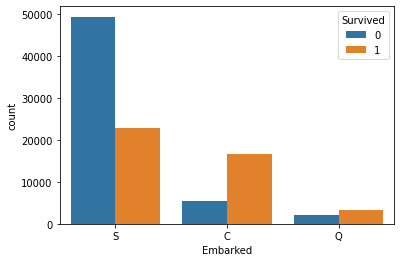

In [47]:
sns.countplot(x='Embarked', hue='Survived', data=data)

Наибольшая доля выживших у людей из 1 класса, наибольшая доля у людей, севших в Q

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [48]:
data.isnull().sum()/data.shape[0]

Survived    0.00000
Pclass      0.00000
Name        0.00000
Sex         0.00000
Age         0.03292
SibSp       0.00000
Parch       0.00000
Ticket      0.04623
Fare        0.00134
Cabin       0.67866
Embarked    0.00250
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Можно пропущенные значения заменить нулями, тогда логистическая регрессия будет учитывать такие признаки только у тех примеров, где эти значения есть (то есть отличны от нуля, иначе они не будут вносить вклад в предсказание)


Также можно заменить пропущенные значения на среднее или медиану.

Для категориальных признаков, пропущенные значения можно заменить наиболее частыми.

На тренировочной выборке можно также выбросить примеры, в которых пропущены значения, если таких немного.

Столбец с каютой лучше выбросить, так как там большинство значений пропущены.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [49]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [50]:
data_cleaned = data.dropna()

In [51]:
cat_feats = ['Sex', 'Embarked', 'Pclass']
num_feats = ['Age', 'SibSp', 'Parch', 'Fare']
target = 'Survived'

X = data_cleaned[cat_feats + num_feats]
y = data_cleaned[target]

### Логистическая регрессия

In [52]:
transformer = ColumnTransformer(
    [
        ('num_scaler', StandardScaler(), num_feats),
        ('cat_encoder', OneHotEncoder(), cat_feats)
    ])

pipeline = Pipeline([
            ('tr', transformer),
            ('clf', LogisticRegression())
])
scores_lr = cross_validate(pipeline, X, y, scoring='accuracy', cv=3, n_jobs=-1)
scores_lr['test_score'].mean()

0.7342378258103559

### KNN

In [53]:
transformer = ColumnTransformer(
    [
        ('num_scaler', StandardScaler(), num_feats),
        ('cat_encoder', OneHotEncoder(), cat_feats)
    ])

pipeline = Pipeline([
            ('tr', transformer),
            ('clf', KNeighborsClassifier())
])
scores_knn = cross_validate(pipeline, X, y, scoring='accuracy', cv=3, n_jobs=-1)
scores_knn['test_score'].mean()

0.7038306723801502

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [54]:
pd.set_option("mode.chained_assignment", None)

In [55]:
SEED = 123

In [56]:
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
99995,1,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C
99996,0,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S
99997,0,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S


In [57]:
def engineer_features(orig_data):
    df = orig_data.copy()
    df.drop('Name', axis=1, inplace=True)
    
    df['AnyMissing'] = np.where(df.isnull().any(axis=1) == True, 1, 0)
    df['EvenParch'] = (df.Parch % 2 == 0).astype(int)
    df['isAlone'] = ((df['Parch'] + df['SibSp']) == 0).astype(int)
    
    for sex in df.Sex.unique():
        for pcl in df.Pclass.unique():
            df['Age'].loc[(df.Sex == sex) & (df.Pclass == pcl) & (df.Age.isna())] = \
            df['Age'].loc[(df.Sex == sex) & (df.Pclass == pcl)].median()
    
    df['Sex'] = df['Sex'].replace({'male': 0, 'female': 1})
    
    df['Embarked'] = df['Embarked'].fillna('X')
    
    df['Fare'] = df['Fare'].fillna(data['Fare'].mean())
    df['Cabin'] = df['Cabin'].fillna('X').map(lambda x: x[0].strip())
    
    df['Ticket'] = df['Ticket'].fillna('X').map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else 'X')
    
    conditions = [
    (df['Fare'] <= 7.91),
    ((df['Fare'] > 7.91) & (df['Fare'] <= 14.454)),
    ((df['Fare'] > 14.454) & (df['Fare'] <= 31)),
    (df['Fare'] > 31)
    ]

    choices = [0, 1, 2, 3]
    df["FareBin"] = np.select(conditions, choices)
    df['FareBin'] = df['FareBin'].astype(int)
    
    conditions = [
    (df['Age'].le(16)),
    (df['Age'].gt(16) & df['Age'].le(32)),
    (df['Age'].gt(32) & df['Age'].le(48)),
    (df['Age'].gt(48) & df['Age'].le(64)),
    (df['Age'].gt(64))
]
    choices = [0, 1, 2, 3, 4]

    df["AgeBin"] = np.select(conditions, choices)

    return df

engineer_features(data)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AnyMissing,EvenParch,isAlone,FareBin,AgeBin
PassengerId,,,,,,,,,,,,,,,
0,1,1,0,44.00,2,0,X,27.14,C,S,1,1,0,2,2
1,0,3,0,31.00,0,0,X,13.35,X,S,1,1,1,1,1
2,0,3,0,0.33,1,2,CA,71.29,X,S,1,1,0,3,0
3,0,3,0,19.00,0,0,A.,13.04,X,S,1,1,1,1,1
4,1,3,0,25.00,0,0,X,7.76,X,S,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1,2,1,62.00,0,0,PC,14.86,D,C,0,1,1,2,3
99996,0,2,0,66.00,0,0,X,11.15,X,S,1,1,1,1,4
99997,0,3,0,37.00,0,0,X,9.95,X,S,1,1,1,1,2


In [58]:
df = engineer_features(data)

In [59]:
X = df.drop(['Survived'], axis=1)
y = df.Survived

In [60]:
label_cols = ['Ticket']
ohk_cols = ['Cabin', 'Embarked']
num_cols = ['Age', 'Fare', 'SibSp', 'Parch']

transformer = ColumnTransformer([
            ('label', OrdinalEncoder(dtype=int), label_cols),
            ('ohk', OneHotEncoder(sparse=False), ohk_cols),
            #('num', PolynomialFeatures(2), num_cols)
], remainder='passthrough')
scaler = StandardScaler()

X = transformer.fit_transform(X)
X = scaler.fit_transform(X)
X = PolynomialFeatures(2, include_bias=False).fit_transform(X)

In [61]:
clf = LogisticRegression(random_state=SEED, max_iter=2000, C=0.001)

In [62]:
cross_val_score(clf, X, y, cv=3, n_jobs=-1).mean()

0.7801800043559924

In [63]:
clf.fit(X, y)

LogisticRegression(C=0.001, max_iter=2000, random_state=123)

In [64]:
subm = pd.read_csv('data/sample_submission.csv', index_col='PassengerId')
X_test = pd.read_csv('data/test.csv', index_col='PassengerId')

In [65]:
test = engineer_features(X_test)
test = transformer.transform(test)
test = scaler.transform(test)
test = PolynomialFeatures(2, include_bias=False).fit_transform(test)

In [66]:
subm['Survived'] = clf.predict(test)
subm.to_csv('data/my_submission.csv')

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

На kaggle получилось 0.795 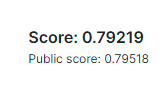